<a href="https://colab.research.google.com/github/audomasdev/SuperAI-SS4-FaceVerification/blob/master/Copy_of_%5BModern_Image_Search%5D_Hands_On_1_Image_Search_Image_(CBIR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-On \#1:** Image Search Image

by Romrawin Chumpu (Jinpu)

AI Lecture - Modern Image Search

Date: January 30, 2024


Reference codes:
1. https://huggingface.co/blog/image-similarity
2. https://github.com/matsui528/sis

In [2]:
!pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00


In [3]:
import cv2
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Download dataset

**Food101** dataset will be used in the course's hands-on.

**Hugging Face** Dataset - https://huggingface.co/datasets

See more:
- https://huggingface.co/datasets/food101
- SOTA: https://paperswithcode.com/dataset/food-101
- https://www.kaggle.com/datasets/dansbecker/food-101

In [4]:
from datasets import load_dataset

# Download dataset
dataset = load_dataset("food101")

# In case you want to try - we can use another dataset by changing "food101" to "beans", "huggan/smithsonian_butterflies_subset", etc.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

After dataset is downloaded, first thing we need to know is what are the features that this dataset provides.

In [5]:
# This will print out the dataset split and high-level feature information
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [6]:
# This will print out specific information about its features
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lo

In [7]:
### Dataset Information ###
print("### Dataset Information ###\n")
print("Number of training images: ", len(dataset["train"]))
print("Number of training images: ", len(dataset["validation"]))
print("Number of labels: ", len(dataset["train"].features["label"].names))

### Dataset Information ###

Number of training images:  75750
Number of training images:  25250
Number of labels:  101


In [8]:
# Check what type of stored data from one sample
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>,
 'label': 6}

In [9]:
# Create a dictionary for changing index labels to string labels
id2label = {}
for i, label in enumerate(dataset["train"].features["label"].names):
  id2label[i] = label

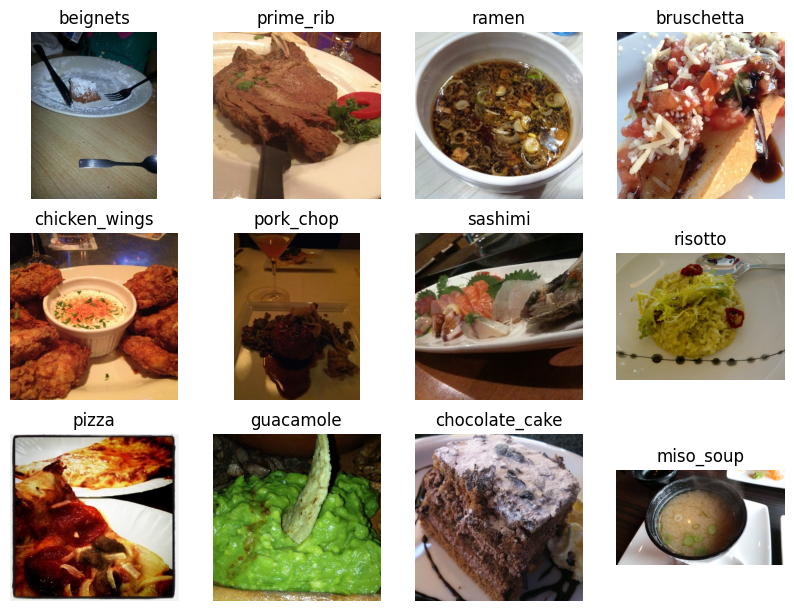

In [10]:
# Sample visualization by using matplotlib
rows = 4; cols = 4
fig = plt.figure(figsize=(10, 10))
c = 0
for i in range(0, 12000, 1000):
  ax = fig.add_subplot(rows, cols, c+1)
  image = dataset["train"][i]["image"]
  plt.imshow(image)
  plt.axis('off')
  plt.title(id2label[dataset["train"][i]["label"]])
  c+=1
plt.show()

# Load pretrained model

We will use pretrianed model in **feature extraction** process.

The models which used to train on this dataset can be found in Hugging Face dataset website.

In our case, we will check on https://huggingface.co/datasets/food101.

In [11]:
# tranformers is already preintslled in Colab recently!
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/food"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

# model options - "Neruoy/swin-finetuned-food101-e3", "eslamxm/vit-base-food101"

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/344M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/food and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Image Searching process



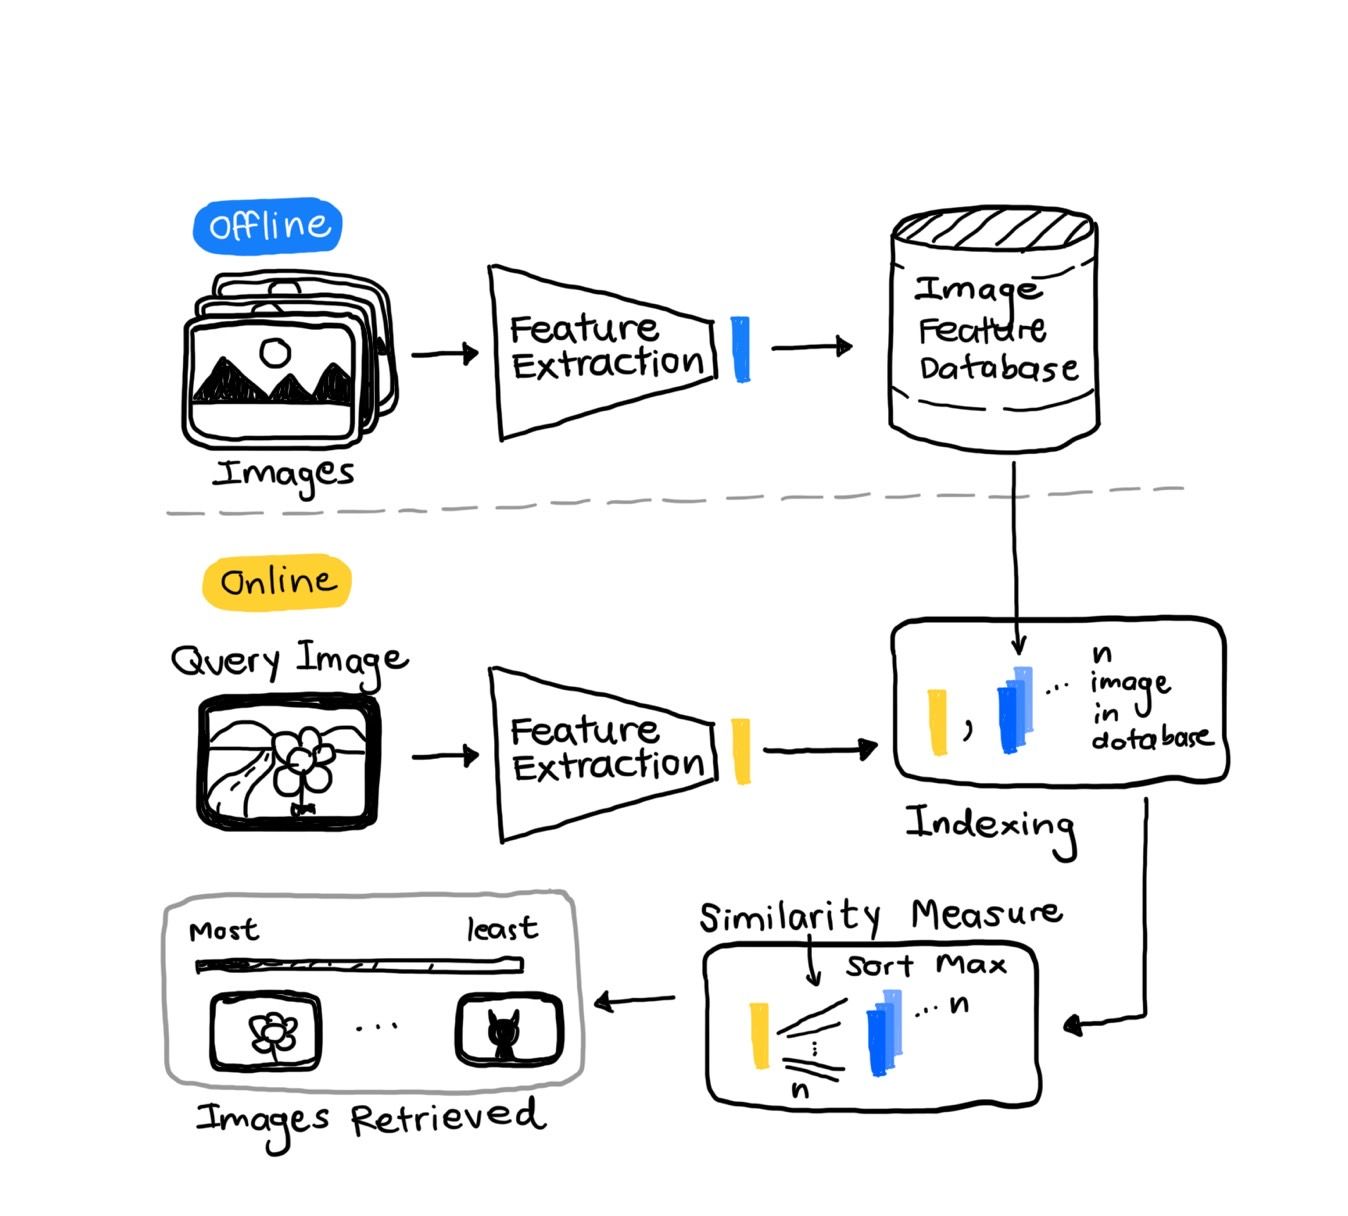

## Offline Stage

In [12]:
num_samples = 1000
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [13]:
import torchvision.transforms as T

# Image transformation
transformation_chain = T.Compose(
    [
        # Resize the image to 256x256 and then take center crop
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [14]:
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def extract(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return extract

In [15]:
############# Creating Embedding Database #####################
# Map embedding extraction utility on our subset of candidate images
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Online Stage

### Indexing embedding space

In [16]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["label"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

print("Sample indexing: ", candidate_ids[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample indexing:  0_74


In [17]:
# Change type from numpy to torch in order to compute cosine similarity
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

### Similarity Measure

We will use **cosine similarity** to measure between two embeddings vectors and query vector.

![cosine sim](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)



In [18]:
# Code originally from https://huggingface.co/blog/image-similarity
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

# Test Image Search

Search for -  6


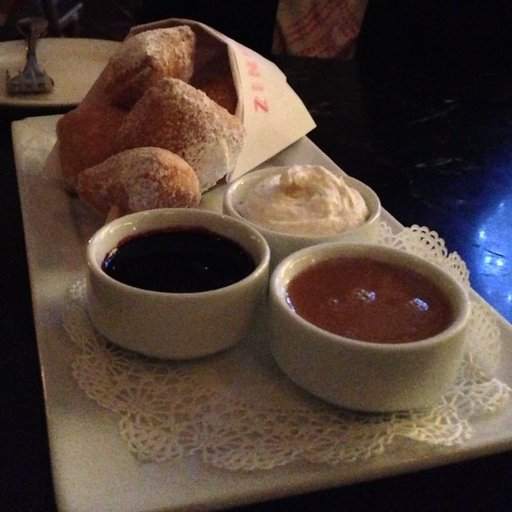

In [29]:
test_idx = 1

# Random - test_idx = np.random.choice(len(dataset["validation"]))

test_sample = dataset["validation"][test_idx]["image"]
test_label = dataset["validation"][test_idx]["label"]
print("Search for - ", test_label)

test_sample

In [26]:
sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 6
Top 5 candidate labels: [31, 31, 31, 31, 31]


# Visualization Image Search Result

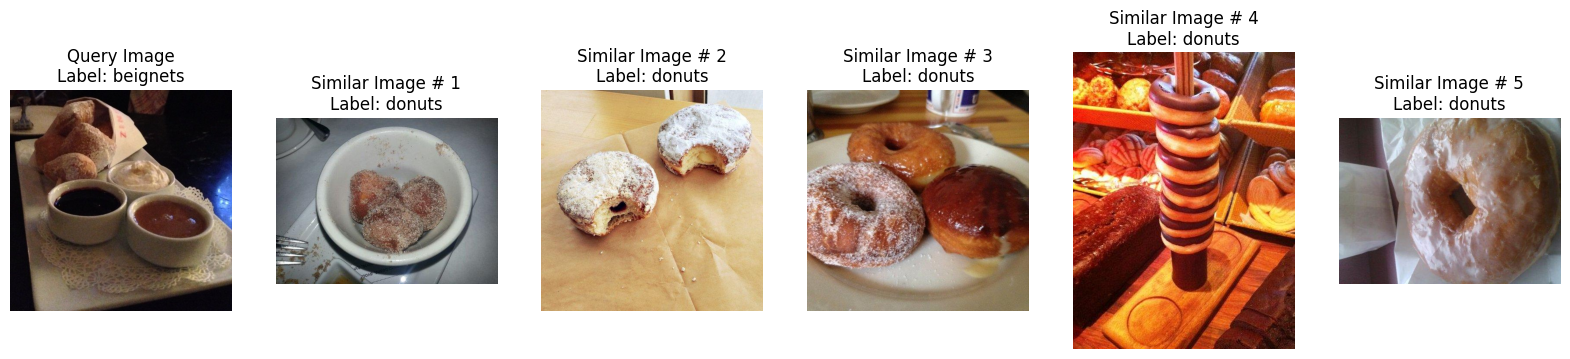

In [27]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)